In [1]:
from collections import defaultdict
from itertools import count


import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np


from mesa import Model, Agent
from mesa.space import SingleGrid
from mesa.datacollection import DataCollector
from mesa.time import RandomActivation



class Animal(Agent):
    _ids = count(0)
    
    def __init__(self, model, energy_repro_treshold):
        super().__init__(next(self._ids), model)
        self.__class__._instances += 1
        self.alive = True
        self.energy_repro_treshold = energy_repro_treshold
    
    def move_to_empty(self, neighbors):
        try:
            move_to = self.random.choice(neighbors['empty'])[0]
        except IndexError:
            pass
        else:
            self.model.grid.move_agent(self, move_to)    

    def die(self):
        self.__class__._instances -= 1
        self.model.scheduler.remove(self)
        self.model.grid.remove_agent(self)
        self.alive = False
            
    def reproduce(self):
        empty = self.get_neighbors()['empty']
        if (self.random.random() < self.p_reproduce) and (empty) and (self.energy >=self.energy_repro_treshold):
            child = self.__class__(self.model)
            self.model.scheduler.add(child)
            self.model.grid.place_agent(child, self.random.choice(empty)[0])

            energy = self.energy/2
            child.energy = energy
            self.energy = energy

    def get_neighbors(self):
        neighbors = defaultdict(list)
        for x, y in self.model.grid.get_neighborhood(self.pos, moore=True):
            cell = self.model.grid[x,y]
            
            if cell is None:
                neighbors['empty'].append(((x,y), cell))
            elif isinstance(cell, Wolf):
                neighbors['wolf'].append(((x,y), cell))
            else:
                neighbors['sheep'].append(((x,y), cell))
            
        return neighbors
    
    def step(self):
        self.energy -= 1
        
        if self.energy < 0:
            self.die()
            

    
class Sheep(Animal):
    _instances = 0
    p_reproduce = 0.05
    
    @property
    def i(self):
        """convert the y-coordinate in the SingleGrid into the row index (i) 
        for the numpy array for the grass"""
        return self.pos[1]
    
    @property
    def j(self):
        """convert the x-coordinate in the SingleGrid into the column index (j) 
        for the numpy array for the grass"""        
        return self.pos[0]
    
    
    def __init__(self, model, energy_repro_treshold=2):
        super().__init__(model, energy_repro_treshold)
        self.energy = self.random.randrange(1, 3)
        
    def step(self):
        super().step()
        
        if self.alive:    
            # move
            neighbors = self.get_neighbors()
            self.move_to_empty(neighbors)
            
            # eat
            energy = self.model.grass[self.i, self.j]
            self.energy += energy
            self.model.grass[self.i, self.j] -= energy            

            # breed
            self.reproduce()            


class Wolf(Animal):
    _instances = 0
    p_reproduce = 0.04
    
    def __init__(self, model, energy_repro_treshold=4):
        super().__init__(model, energy_repro_treshold)
        self.energy = self.random.randrange(1, 6)
    
    def step(self):
        super().step()

        if self.alive:
            # still alive
            neighbors = self.get_neighbors()

            try:
                move_to, sheep = self.random.choice(neighbors['sheep'])
            except IndexError:
                self.move_to_empty(neighbors)
            else:
                sheep.die()
                self.energy += sheep.energy
                self.model.grid.move_agent(self, move_to)
            
            self.reproduce()


class PredatorPreyModel(Model):
    
    def __init__(self, width=20, height=20, sheep_density=0.20, wolf_density=0.01,
                regrowth_p=0.1, seed=None):
        super().__init__(seed=seed)
        np.random.seed(seed)
        Wolf._instances = 0
        Sheep._instances = 0
        self.width = width
        self.height = height
        self.regrowth_p = regrowth_p
        
        self.grid = SingleGrid(self.height, self.width, torus=True)
        self.grass = np.ones((self.height, self.width))
        self.scheduler = RandomActivation(self)
        self.datacollector = DataCollector({'wolves' : lambda m: m.count_animal(Wolf),
                                            'sheep' : lambda m: m.count_animal(Sheep),
                                            'grass' : lambda m: np.sum(m.grass)})
        
        n_cells = width * height
        n_sheep = int(round(sheep_density * n_cells))
        n_wolves = int(round(wolf_density * n_cells))
        
        for klass, n in ((Wolf, n_wolves),(Sheep, n_sheep)):
            for _ in range(n):
                agent = klass(self)
                pos = self.random.choice(list(self.grid.empties))
                self.grid.place_agent(agent, pos)
                self.scheduler.add(agent)
        
        self.datacollector.collect(self)
        
    def step(self):
        # regrow grass
        self.grass[self.grass != 0] += 1/3
        self.grass[(model.grass == 0) & (np.random.rand(*model.grass.shape) <= self.regrowth_p)] = 1/3    
        self.grass = np.minimum(self.grass, 5)
        
        self.scheduler.step()
        self.datacollector.collect(self)

    def count_animal(self, klass):
        return klass._instances


def visualize_model(model):
    green = sns.color_palette()[2] + (1,)
    red = sns.color_palette()[3] + (1,)
    transparent = sns.color_palette()[3] + (0,)
    
    x = []
    y = []
    colors = []
    for i, row in enumerate(model.grid._grid):
        for j, cell in enumerate(row):
            x.append(i)
            y.append(j)
            
            if cell:
                color = red if isinstance(cell, Wolf) else green
            else:
                color = transparent
            
            colors.append(color)
        
    sns.set_style('white')
    
    fig, ax = plt.subplots()
    ax.imshow(model.grass, vmin=0, vmax=5, cmap='viridis', origin='lower')
    ax.scatter(x,y, s=200, c=np.asarray(colors, dtype=object))
    ax.set_aspect('equal')
    # ax.set_xticks([])
    # ax.set_yticks([])
    
    return fig
    
    

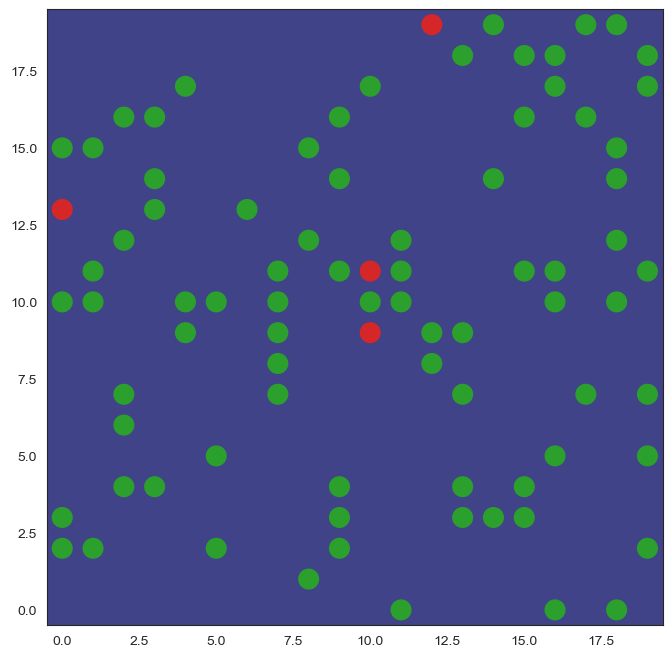

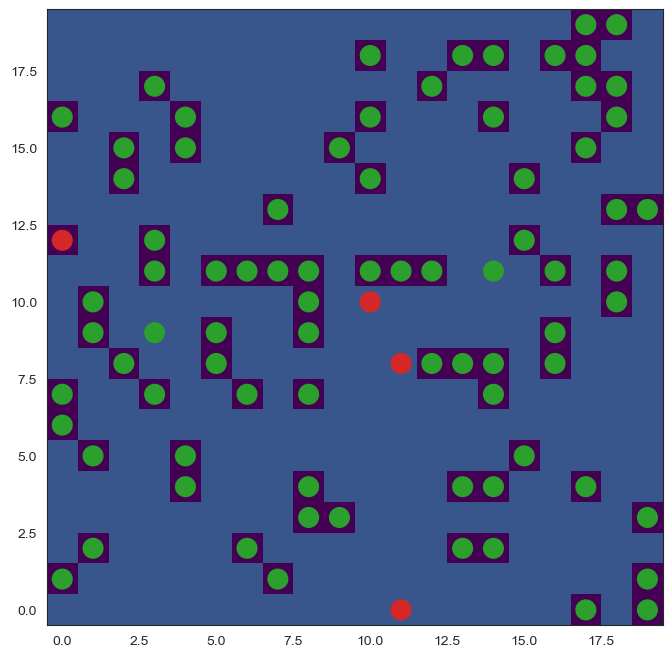

In [2]:
model = PredatorPreyModel()
visualize_model(model)
model.step()
visualize_model(model)
plt.show()

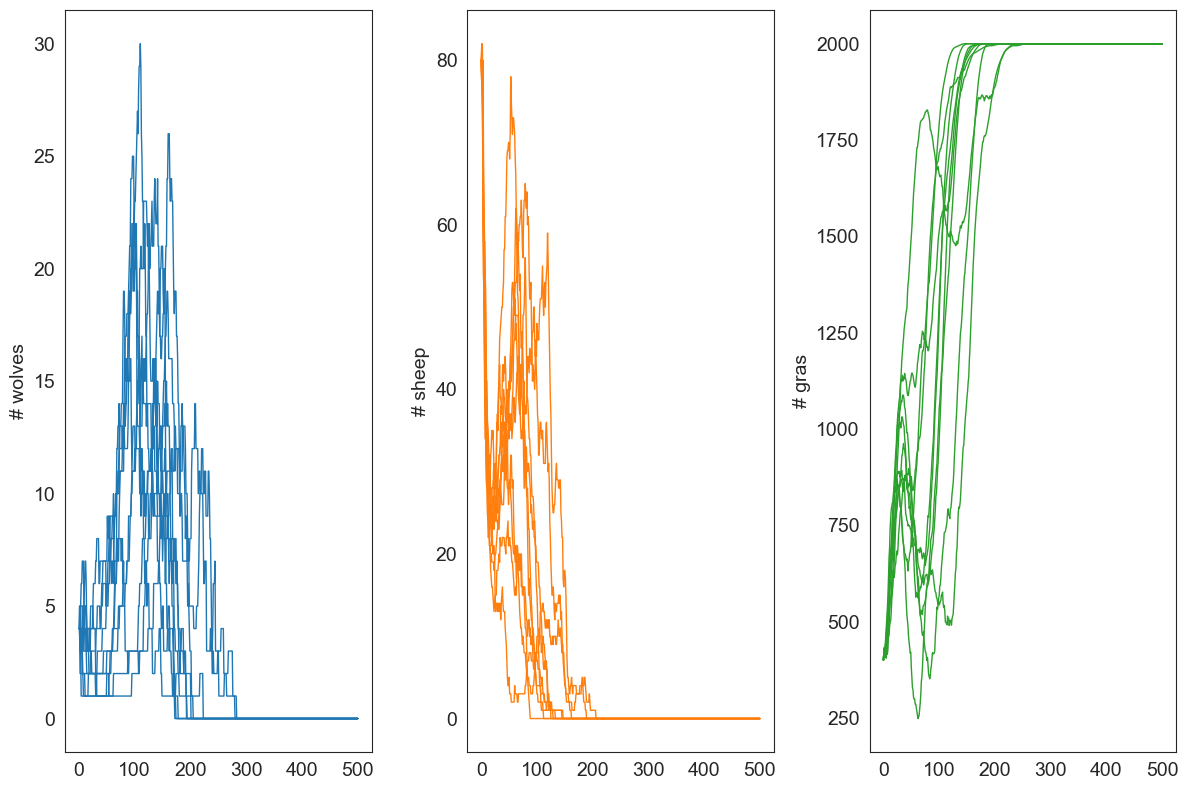

In [3]:
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3)
ax1.set_ylabel('# wolves')
ax2.set_ylabel('# sheep')
ax3.set_ylabel('# gras')


for i in range(10):
    model = PredatorPreyModel(seed=i)
    for _ in range(500):
        model.step()
    data = model.datacollector.get_model_vars_dataframe()
    ax1.plot(data.wolves, color=sns.color_palette()[0], lw=1)
    ax2.plot(data.sheep, color=sns.color_palette()[1], lw=1)
    ax3.plot(data.grass, color=sns.color_palette()[2], lw=1)

change_fontsize(fig, 14)
plt.tight_layout()
plt.show()





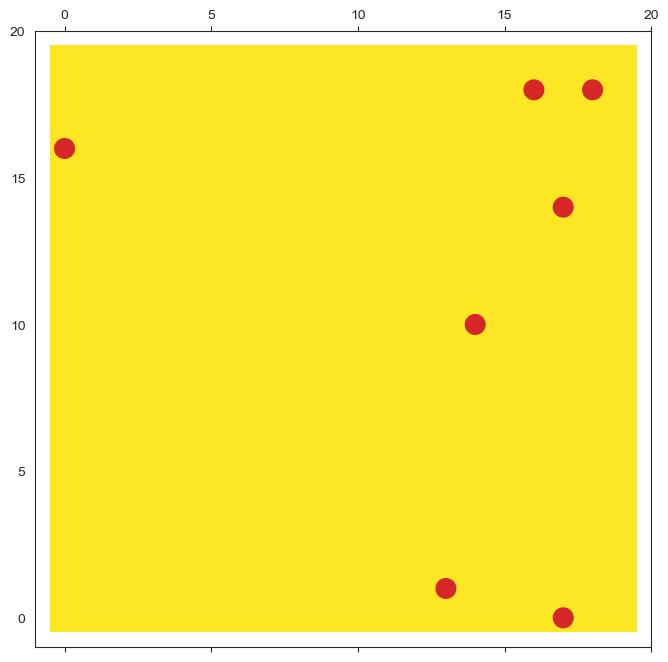

In [4]:
from matplotlib.animation import FuncAnimation
from matplotlib import animation

model = PredatorPreyModel(seed=12345678)
agents = model.scheduler.agents


sns.set_style('white')
green = sns.color_palette()[2] + (1,)
red = sns.color_palette()[3] + (1,)
transparent = sns.color_palette()[3] + (0,)

x = []
y = []
colors = []
for i, row in enumerate(model.grid._grid):
    for j, cell in enumerate(row):
        x.append(i)
        y.append(j)

        if cell:
            color = red if isinstance(cell, Wolf) else green
        else:
            color = transparent

        colors.append(color)


fig, ax = plt.subplots()
ax.set_xlim(-1, model.grid.width)
ax.set_ylim(-1, model.grid.height)
ax.set_xticks([])
ax.set_yticks([])
ax.set_aspect('equal')

grass = ax.matshow(model.grass, vmin=0, vmax=5, cmap='viridis')
positions = ax.scatter(x,y, s=200, c=np.asarray(colors, dtype=object))

def update(frame):
    model.step()

    colors = []
    for i, row in enumerate(model.grid._grid):
        for j, cell in enumerate(row):
            if cell:
                color = red if isinstance(cell, Wolf) else green
            else:
                color = transparent

            colors.append(color)
    positions.set_color(np.asarray(colors, dtype=object))
    grass.set_data(model.grass)
    
    return positions, grass

anim = FuncAnimation(fig, update, frames=200);
writervideo = animation.FFMpegWriter(fps=6) 
anim.save("test.mp4", writer=writervideo)

In [5]:
from IPython.display import Video

Video("test.mp4", width=600)

# experiments

change regrowth probability and ask to explain behavior in terms of delays....

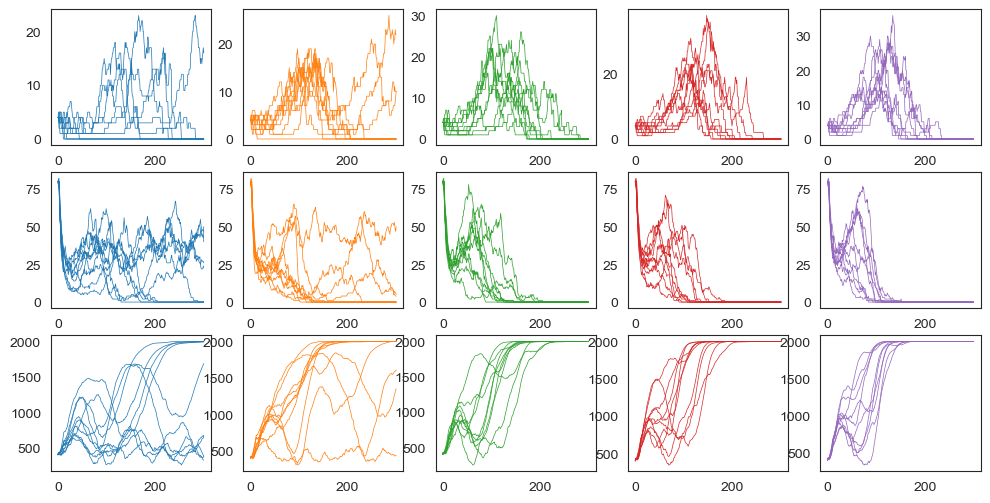

In [7]:
from collections import defaultdict


fig, axes = plt.subplots(nrows=3, ncols=5,
                        figsize=(12,6))
axes1, axes2, axes3 = axes

results = defaultdict(list)
for i, p in enumerate([0.05, 0.075, 0.1, 0.125, 0.15]):
    color = sns.color_palette()[i]
    
    ax1 = axes1[i]
    ax2 = axes2[i]
    ax3 = axes3[i]
    
        
    for s in range(10):
        model = PredatorPreyModel(regrowth_p=p, seed=s)
        for _ in range(300):
            model.step()
        data = model.datacollector.get_model_vars_dataframe()
        ax1.plot(data.wolves, color=color, lw=0.5, alpha=1)
        ax2.plot(data.sheep, color=color, lw=0.5, alpha=1) 
        ax3.plot(data.grass, color=color, lw=0.5, alpha=1)         

        # results[(sheep_density, wolf_density)].append(data)

plt.show()

